In [1]:
import os
from pathlib import Path
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from utils import *
from preprocess import preprocess
from dataset import MTDataset
from model import LinReg, dnn

In [2]:
# Fix randon seed for reproducibility
same_seeds(0)
os.chdir("/root/Master_Thesis/cost_model")

## Analyze Dataset

In [2]:
train_data_path = Path("dataset") / "train_data"

train_logs = {
    "n_traces" : 0,
    "n_samples" : 0,
    "n_samples_of_trace" : [],
}

data_subdirs = [file for file in train_data_path.iterdir() if file.is_dir()]
for subdir in data_subdirs:
    for file in subdir.iterdir():
        df = pd.read_csv(file)
        train_logs["n_traces"] += 1
        train_logs["n_samples"] += len(df)
        train_logs["n_samples_of_trace"].append(len(df))

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train_data'

<Axes: xlabel='n_samples_of_trace', ylabel='Count'>

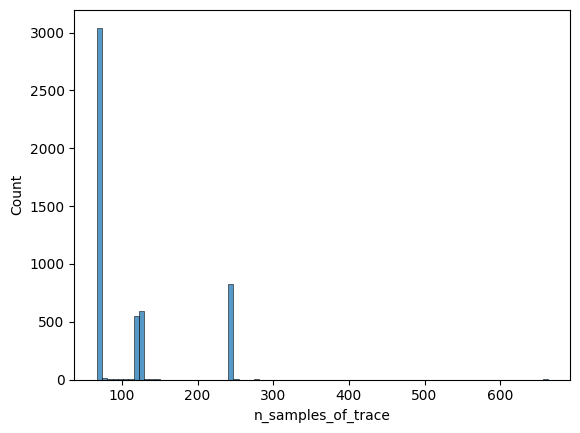

In [36]:
sns.histplot(data=train_logs, x="n_samples_of_trace")

In [30]:
test_data_path = Path("dataset") / "testing_data/fio_known"

test_logs = {
    "n_traces" : 0,
    "n_samples" : 0,
    "n_samples_of_trace" : [],
}

data_subdirs = [file for file in test_data_path.iterdir() if file.is_dir()]
for subdir in data_subdirs:
    for file in subdir.iterdir():
        df = pd.read_csv(file)
        test_logs["n_traces"] += 1
        test_logs["n_samples"] += len(df)
        test_logs["n_samples_of_trace"].append(len(df))


<Axes: xlabel='n_samples_of_trace', ylabel='Count'>

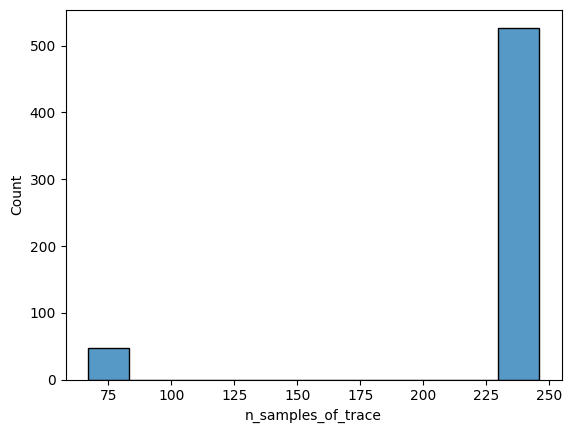

In [33]:
sns.histplot(data=test_logs, x="n_samples_of_trace")

## Analyze Linear Regression Model

In [3]:
model_path = Path("param") / "LinReg.pickle"
with model_path.open("rb") as f:
    clf = pickle.load(f)

counter_path = Path("dataset") / "counters.txt"
with counter_path.open("r") as f:
    counters = f.readlines()

coefficients = clf.coef_
df = pd.DataFrame({
    "Counters" : counters,
    "Coefficients" : coefficients,
})
print(df)

                               Counters  Coefficients
0          Cache\Async Copy Reads/sec\n      0.126929
1           Cache\Async Data Maps/sec\n    118.330155
2          Cache\Async Fast Reads/sec\n   -151.025199
3           Cache\Async MDL Reads/sec\n    -25.603458
4           Cache\Async Pin Reads/sec\n   -989.102482
..                                  ...           ...
99         System\File Read Bytes/sec\n      0.000007
100   System\File Read Operations/sec\n      0.062837
101       System\File Write Bytes/sec\n      0.000012
102  System\File Write Operations/sec\n     -0.118635
103       System\Processor Queue Length   1506.126178

[104 rows x 2 columns]


Text(0.5, 0, 'Counter')

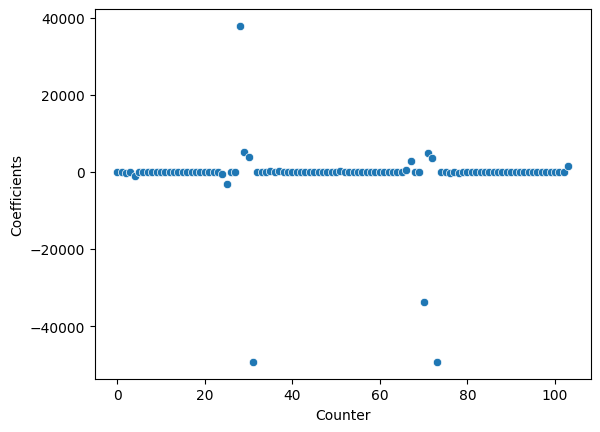

In [4]:
sns.scatterplot(data=df["Coefficients"])
plt.xlabel("Counter")

In [5]:
# coefficient > 10000
pos_coefficient = np.abs(df["Coefficients"])
print(df[pos_coefficient > 10000])

                                            Counters  Coefficients
28     LogicalDisk(D:)\Avg. Disk Read Queue Length\n  37883.351944
31             LogicalDisk(D:)\Avg. Disk sec/Write\n -49271.810246
70  PhysicalDisk(1 D:)\Avg. Disk Read Queue Length\n -33766.173675
73          PhysicalDisk(1 D:)\Avg. Disk sec/Write\n -49184.168219


In [6]:
# coefficient > 1000
pos_coefficient = np.abs(df["Coefficients"])
print(df[pos_coefficient > 1000])

                                              Counters  Coefficients
25                 LogicalDisk(D:)\% Disk Write Time\n  -3023.435621
28       LogicalDisk(D:)\Avg. Disk Read Queue Length\n  37883.351944
29      LogicalDisk(D:)\Avg. Disk Write Queue Length\n   5140.752714
30                LogicalDisk(D:)\Avg. Disk sec/Read\n   3760.614972
31               LogicalDisk(D:)\Avg. Disk sec/Write\n -49271.810246
67              PhysicalDisk(1 D:)\% Disk Write Time\n   2920.504164
70    PhysicalDisk(1 D:)\Avg. Disk Read Queue Length\n -33766.173675
71   PhysicalDisk(1 D:)\Avg. Disk Write Queue Length\n   5036.017565
72             PhysicalDisk(1 D:)\Avg. Disk sec/Read\n   3709.681794
73            PhysicalDisk(1 D:)\Avg. Disk sec/Write\n -49184.168219
103                      System\Processor Queue Length   1506.126178


In [9]:
data_cpath = Path("cache") / "test_data.pickle"
with data_cpath.open("rb") as f:
    data = pickle.load(f)
instances, labels = data["instances"], data["labels"]
y_preds = clf.predict(instances)

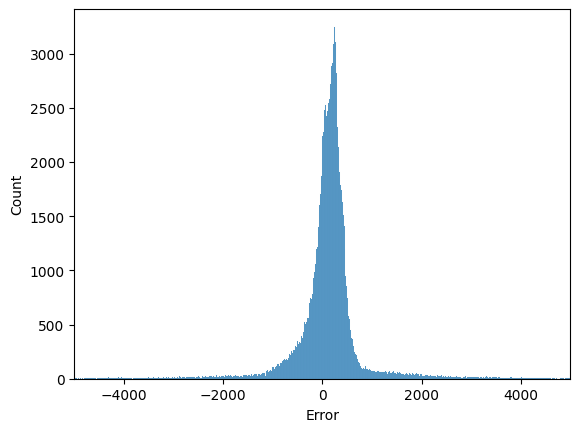

In [10]:
err = labels - y_preds
sns.histplot(data=err)
plt.xlim(-5000, 5000)
plt.xlabel("Error")
plt.show()

## Analyze Label

In [17]:
print("Maximum throughput : {}; Minimum throughput : {}; Avg throughput : {}".format(np.max(labels), np.min(labels), np.mean(labels)))

Maximum throughput : 101507.6015625; Minimum throughput : 0.0; Avg throughput : 10593.677734375


### Distribution

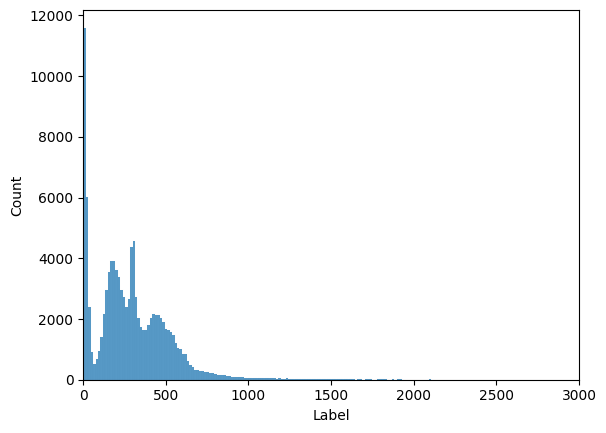

In [27]:
sns.histplot(data=labels)
plt.xlim(0, 3000)
plt.xlabel("Label")
plt.show()

### CDF

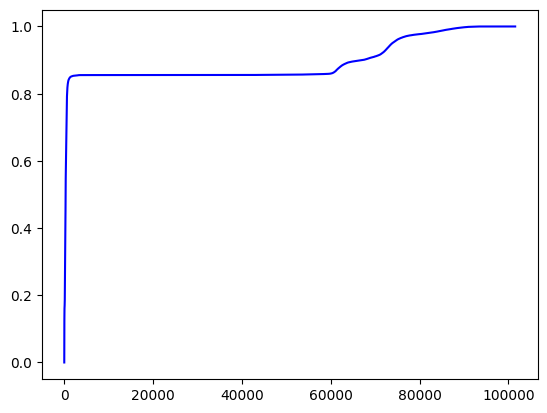

In [24]:
sorted_label = np.sort(labels)
cdf = np.linspace(0, 1, len(sorted_label))
plt.plot(sorted_label, cdf, color='blue', label='CDF')

In [38]:
print("Ratio of common throughput : {}".format(len(labels[labels < 1000]) / len(labels)))

Ratio of common throughput : 0.8419357599047834


In [33]:
print("Ratio of smaller throughput : {}".format(len(labels[labels < 20]) / len(labels)))

Ratio of smaller throughput : 0.10963134680160873


In [40]:
print("Ratio of zero throughput : {}".format(len(labels[labels < 0.1]) / len(labels)))

Ratio of zero throughput : 0.0006923429976118056
